# NLP - LASER Embeddings + Keras

This approach encodes the tweets using [LASER](https://github.com/yannvgn/laserembeddings) multilingual sentence embeddings,
followed by a [TF Keras](https://www.tensorflow.org/api_docs/python/tf/keras) dense neural network.

In [ ]:
!pip install -q laserembeddings laserembeddings[zh] laserembeddings[ja]
!pip install -q ftfy

In [ ]:
# import fasttext
import ftfy
import html
import laserembeddings
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import sys

from fastcache import clru_cache
from laserembeddings import Laser
from typing import List, Union
from urllib.parse import unquote
from sklearn.model_selection import train_test_split

In [ ]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', index_col=0).fillna('')
df_test  = pd.read_csv('../input/nlp-getting-started/test.csv',  index_col=0).fillna('')
df_train

# Preprocess Text

Keyword, location and text fields into a single string. 

Simple preprocessing is performed to remove HTML and encoded elements, @usernames, hashtag prefixes and urls.

In [ ]:
def preprocess_text(df):
    texts = df[['keyword', 'location', 'text']].agg(' '.join, axis=1)
    texts = texts.apply(ftfy.fix_text)   # fix \x89
    texts = texts.apply(html.unescape)  
    texts = texts.apply(unquote)         # remove %20
    texts = texts.apply(lambda s: re.sub('@\w+', ' ', s))            # remove @usernames
    texts = texts.apply(lambda s: re.sub('#',    ' ', s))            # remove hashtag prefixes    
    texts = texts.apply(lambda s: re.sub('\n',   ' ', s))            # remove newlines
    texts = texts.apply(lambda s: re.sub('\w+://\S+',  '<URL>', s))  # remove urls    
    texts = texts.apply(lambda s: re.sub('\s+',  ' ', s))            # remove multiple spaces    
    return list(texts)
    
preprocess_text(df_train)[:10]
preprocess_text(df_test)[:10]

# LASER Embeddings

This encodes each of the strings as a LASER embedding (1024 dimentional vector)

In [ ]:
%%bash
# DOCS: https://github.com/facebookresearch/LASER/blob/master/install_models.sh

mkdir -p models/laser/
# for FILE in bilstm.eparl21.2018-11-19.pt eparl21.fcodes eparl21.fvocab bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
for FILE in bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
    wget -cq https://dl.fbaipublicfiles.com/laser/models/$FILE -O models/laser/$FILE
done

In [ ]:
# from config import config
# from src.utils.fasttest_model import language_detect
# from src.utils.punkt_tokenizer import punkt_tokenize_sentences

config = {
    "laser": {
        "base_dir":  "./models/laser",
        "bpe_codes": "./models/laser/93langs.fcodes",
        "bpe_vocab": "./models/laser/93langs.fvocab",
        "encoder":   "./models/laser/bilstm.93langs.2018-12-26.pt",
    }
}

# Instantiate encoder
# BUG: CUDA GPU memory is exceeded if both laser and labse are loaded together 
# @clru_cache(None)
def get_laser_model():
    laser_model = Laser(
        bpe_codes = config['laser']['bpe_codes'],
        bpe_vocab = config['laser']['bpe_vocab'],
        encoder   = config['laser']['encoder'],
        tokenizer_options = None,
        embedding_options = None
    )
    return laser_model


def laser_encode(text: Union[str, List[str]], lang='en', normalize=True) -> np.ndarray:
    """
    Encodes a corpus of text using LASER
    :param text: Large block of text (will be tokenized), or list of pre-tokenized sentences
    :param lang: 2 digit language code (optional autodetect)
    :return:     embedding matrix
    """
    laser_model = get_laser_model()
    
    # lang = lang or language_detect(text, threshold=0.0)
    if isinstance(text, str):
        # sentences = punkt_tokenize_sentences(text, lang=lang)
        sentences = [ text ]
    else:
        sentences = list(text)

    embedding = laser_model.embed_sentences(sentences, lang=lang)
    
    if normalize:
        embedding = embedding / np.sqrt(np.sum(embedding**2, axis=1)).reshape(-1,1)
        
    return embedding

In [ ]:
%%time 

X_train = laser_encode(preprocess_text(df_train))
Y_train = df_train['target']

print('X_train.shape', X_train.shape)
print('Y_train.shape', Y_train.shape)

In [ ]:
df_train

In [ ]:
X_train

In [ ]:
Y_train

# Neural Network - TF Keras

Define and train a dense neural network. 

This inputs a 1024 LASER embedding and outputs a 1 bit classification prediction.

A triangular shaped architecture is used, including Dropout and BatchNorm.

In [39]:
# DOCS: https://keras.io/examples/keras_recipes/antirectifier/

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1024,)),
    tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
])
"""
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1024,)),
    tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
])
"""

def model_compile_fit(model, X, Y):
    log_dir = 'logs'
    model.summary()
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
        
    # Compile the model
    model.compile(
        loss      = tf.keras.losses.BinaryCrossentropy(from_logits=True),
        # optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
        metrics   = [ tf.keras.metrics.BinaryAccuracy() ],
    )
    
    # Train the model
    # add history and tensorboard
    history=model.fit(
        X_train, Y_train, 
        batch_size = 32, 
        epochs     = 1000, 
        validation_split = 0.2,
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10),
            tf.keras.callbacks.ModelCheckpoint('model.h5',  monitor='binary_accuracy', mode='max', verbose=0, save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)
        ],
        verbose=2
    )
    model.save('model.h5')
    
    print()
    print('Train Accuracy')
    model.evaluate(X_train, Y_train)

    print('Test Accuracy')
    model.evaluate(X_test, Y_test)
    return history

    
history=model_compile_fit(model, X_train, Y_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dense_21 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dense_22 (Dense)             (None, 32)               

In [42]:
tf.keras.metrics.BinaryAccuracy()

In [46]:
import matplotlib.pylab as plt

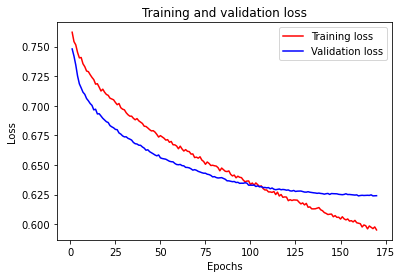

<Figure size 432x288 with 0 Axes>

In [47]:
def plot_history(history):
    # Setting
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    #acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Plotting loss
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    """
    # Plotting accuracy
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    """
    plt.show()


plot_history(history)

In [48]:
%load_ext tensorboard
#%load_ext tensorboard.notebook

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 136), started 0:56:37 ago. (Use '!kill 136' to kill it.)

# Submission

In [ ]:
preprocess_text(df_test)

In [ ]:
%%time 

X_test = laser_encode(preprocess_text(df_test))
Y_test = tf.math.round( model.predict(X_test) ).numpy().astype(np.int32)

In [ ]:
pd.read_csv('../input/nlp-getting-started/sample_submission.csv', index_col=0)

In [ ]:
df_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv', index_col=0).fillna('')
df_submission['target'] = Y_test
df_submission.to_csv('submission.csv')
!head submission.csv

In [27]:
df_submission

,target
id,
0,0
2,0
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


# Further Reading

This notebook is part of a series exploring Natural Language Processing
- 0.74164 - [NLP Logistic Regression](https://www.kaggle.com/jamesmcguigan/disaster-tweets-logistic-regression)
- 0.76677 - [NLP LASER Embeddings + Keras](https://www.kaggle.com/jamesmcguigan/nlp-laser-embeddings-keras)
- 0.77536 - [NLP TF-IDF Classifier](https://www.kaggle.com/jamesmcguigan/disaster-tweets-tf-idf-classifier)
- 0.79742 - [NLP Naive Bayes](https://www.kaggle.com/jamesmcguigan/nlp-naive-bayes)